# Разработка механизма ранжирования комментариев с помощью моделей машинного обучения

Любая социальная сеть это не только просмотр страничек людей и новостной ленты, но и в первую очередь общение. В ходе общения некоторые комментарии оказываются более популярными, чем другие. И как следствие нахотятся выше в ленте. Необходимо выяснить, а что же влияет на то что комментарий будет популярен или нет? Необходимо проинализировать данные и возможно найдутся инсайды, которые ответят на данный вопрос. В дальнейшем эти рекоммендации могут быть выданы пользователям, как писать комментарий, чтобы он был более был популярен. Качественное, интересное, а главное аттрактивное общение может увеличить количество пользоватей в социальной сети, а так же время нахожнения в ней

# Постановка задачи

Предложить механизм сортировки комментариев к постам по их популярности на основе методов
машинного обучения, чтобы модель могла как можно лучше ранжировать пользовательские комментарии.
Для этого:
1. Провеcти проверку и разведочный анализ данных (EDA) и подумать, какие готовые решения можно использовать для представления текста.
2. Используя тренировочную и тестовую выборки датасета, обучить модель ранжировать текстовые комментарии в порядке их популярности (от популярных к менее популярным).
3. Проанализировать полученные результаты и сформулировать полезные инсайты о том, что обычно содержит популярный комментарий, чтобы команда VK могла использовать эту информацию для улучшения комментариев своих пользователей.
4. Предложите методы взаимодействия с комментаторами, а также механизмы поддержки для разных групп пользователей, включая тех, чьи комментарии непопулярны.

# Описание данных

В формате json представлены данные о постах, комметариях, рейтинге.
После пребразования json в pandas.DataFrame мы имеем следующие колонки:

`post_idx` - индекс поста

`text` - текст поста

`comments` - комментарий к посту (на каждый пост имеется 5 комментариев с разным рейтингом)

`score` - рейтинг популярности комментария (от 0 до 4, где 0 - самый популярный)

# Метрика оценки качества модели

NDCG

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ndcg_score.html



In [ ]:
# импортируем необходимые библиотеки
import numpy as np
import pandas as pd
import json
import re
import csv
import urllib.request

from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, DistilBertModel, DataCollatorWithPadding, AutoModelForSequenceClassification, TFAutoModelForSequenceClassification



import scipy.stats as stats
from scipy.special import softmax
pd.options.display.max_columns=300

from warnings import filterwarnings
filterwarnings('ignore')

In [ ]:
# заведем цветовые палитры

cmap_vk = ListedColormap(['#0077FF','#811AC7', '#FF0084', '#00EAFF', '#BEB6AE', '#00DC7F', '#212121', '#DEDEDE', '#FFFFFF'])
colors_vk = ['#0077FF','#811AC7', '#FF0084', '#00EAFF', '#BEB6AE', '#00DC7F', '#212121', '#DEDEDE', '#FFFFFF']

In [ ]:
params = {
    'figure.figsize': [10, 8],
    'axes.grid': False,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'axes.labelsize': 12,
    'axes.edgecolor': 'white',
    'image.cmap': cmap_vk,
    'lines.linewidth': 1,
    'lines.color': 'gray'
}

plt.rcParams.update(params)

### Загрузка и преобразование данных

In [ ]:
train = pd.read_json('/data/ranking_train.jsonl', lines=True)
test  = pd.read_json('/data/ranking_test.jsonl', lines=True)

In [ ]:
# "развернем" формат json в датафрейм
train_data = train.copy()
test_data = test.copy()

train_data = train_data.explode('comments')
test_data = test_data.explode('comments')

train_data['comment'] = train_data['comments'].map(lambda x: x['text'])
test_data['comment'] = test_data['comments'].map(lambda x: x['text'])
train_data['score'] = train_data['comments'].map(lambda x: x['score'])
test_data['score'] = test_data['comments'].map(lambda x: x['score'])

train_data = train_data.reset_index()
# test_data = test_data.reset_index()
train_data = train_data.rename(columns={'index': 'post_idx'})
test_data = test_data.rename(columns={'index': 'post_idx'})

train_data = train_data.drop('comments', axis=1)
test_data = test_data.drop('comments', axis=1)

train_data = train_data.rename(columns={'comment': 'comments'})
test_data = test_data.rename(columns={'comment': 'comments'})

In [ ]:
train_data.head(10)

,post_idx,text,comments,score
0,0,How many summer Y Combinator fundees decided n...,Going back to school is not identical with giv...,0
1,0,How many summer Y Combinator fundees decided n...,There will invariably be those who don't see t...,1
2,0,How many summer Y Combinator fundees decided n...,For me school is a way to be connected to what...,2
3,0,How many summer Y Combinator fundees decided n...,I guess it really depends on how hungry you ar...,3
4,0,How many summer Y Combinator fundees decided n...,I know pollground decided to go back to school...,4
5,1,CBS acquires last.fm for $280m,It will be curious to see where this heads in ...,0
6,1,CBS acquires last.fm for $280m,Does this mean that there's now a big-name com...,1
7,1,CBS acquires last.fm for $280m,Also on BBC News: http://news.bbc.co.uk/1/low...,2
8,1,CBS acquires last.fm for $280m,I don't understand what they do that is worth ...,3
9,1,CBS acquires last.fm for $280m,sold out too cheaply. given their leadership p...,4


In [ ]:
train_data.shape, test_data.shape

((440535, 4), (70020, 3))

In [ ]:
train = train_data.iloc[:356535]
valid = train_data.iloc[356535:]

In [ ]:
train.shape, valid.shape, test_data.shape

((356535, 4), (84000, 4), (70020, 3))

### Создание эмбеддингов на основе комментариев и постов

In [ ]:
# Функции для получения эмбеддингов

@torch.inference_mode()
def get_embeddings(model, loader):
    from tqdm import tqdm

    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    torch.cuda.empty_cache()
    model = model.to(device)
    model.eval()

    total_embeddings = []
    idx_list = []

    for batch in tqdm(loader):
        idx_list.append(batch['index'].unsqueeze(1))
        batch = {key: batch[key].to(device) for key in ['attention_mask', 'input_ids']}
        embeddings = model(**batch)['last_hidden_state'][:, 0, :]
        total_embeddings.append(embeddings.cpu())

    return torch.cat(total_embeddings, dim=0), torch.cat(idx_list, dim=0).to(torch.int64)

In [ ]:
def text2emb(
    df: pd.DataFrame,
    text_col_name: str,
    comment_col_name: str,
    emb_size: int=768,
    pca_text=None,
    pca_comm=None
): # -> tupple[pd.DataFrame, sklearn.decomposition._pca.PCA, sklearn.decomposition._pca.PCA]
    """Функция преобразования текстов в датафрейме в эмбеддинги с помощью DistilBertModel
    На вход принмает df, название колонок для преобразования, желаемый размер эмбеддига.
    Если мы хотим реализовать подход PCA: .fit_tranform - для обучающей выборки,
    transform - для тестовой, неободимо пердать заранее предобученные объекты класса PCA()
    """

    def get_pyarrow(df): ### convert to Huggingface dataset
        import pyarrow as pa
        import pyarrow.dataset as ds
        from datasets import Dataset

        dataset = ds.dataset(pa.Table.from_pandas(df).to_batches())

        return Dataset(pa.Table.from_pandas(df))


    def tokenization_text(example):
        return tokenizer.batch_encode_plus(example[text_col_name], add_special_tokens=True,
                                       return_token_type_ids=False, truncation=True)


    def tokenization_comment(example):
        return tokenizer.batch_encode_plus(example[comment_col_name], add_special_tokens=True,
                                       return_token_type_ids=False, truncation=True)



    tokenizer = AutoTokenizer.from_pretrained('distilbert-base-cased')
    model = DistilBertModel.from_pretrained('distilbert-base-cased')

    # Подготовка данных для передачи в модель
    df = df.copy().reset_index()
    text_df = df[['index', text_col_name]]
    comment_df = df[['index', comment_col_name]]

    text_dataset = get_pyarrow(text_df)
    comment_dataset = get_pyarrow(comment_df)

    text_dataset = text_dataset.map(tokenization_text, batched=True)
    comment_dataset = comment_dataset.map(tokenization_comment, batched=True)

    text_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", 'index'])
    comment_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", 'index'])

    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
    text_loader = DataLoader(text_dataset, batch_size=32,
                             collate_fn=data_collator, pin_memory=True, shuffle=False)
    comment_loader = DataLoader(comment_dataset, batch_size=32,
                                collate_fn=data_collator, pin_memory=True, shuffle=False)

    # Получение эмбеддингов
    embeddings_text, idx_text = get_embeddings(model, text_loader)
    embeddings_comment, idx_com = get_embeddings(model, comment_loader)

    # Преобразование эмбедингов длинны 768 в вектора нужной размерности
    if emb_size != 768:
        if pca_text and pca_comm:
            embeddings_text = pca_text.transform(embeddings_text)
            embeddings_comment = pca_comm.transform(embeddings_comment)

        pca_text = PCA(n_components=emb_size)
        pca_comm = PCA(n_components=emb_size)

        embeddings_text = pca_text.fit_transform(embeddings_text)
        embeddings_comment = pca_comm.fit_transform(embeddings_comment)
    else:
        embeddings_text = embeddings_text.numpy()
        embeddings_comment = embeddings_comment.numpy()

    # Собирание итогового df
    text_df = pd.DataFrame(np.concatenate((embeddings_text, idx_text.numpy()), axis=1))
    comment_df = pd.DataFrame(np.concatenate((embeddings_comment, idx_com.numpy()), axis=1))


    text_df = text_df.add_prefix('text_')
    text_df = text_df.rename(columns={text_df.columns[-1]: 'index'})
    comment_df = comment_df.add_prefix('comm_')
    comment_df = comment_df.rename(columns={comment_df.columns[-1]: 'index'})

    text_df['index'] = text_df['index'].astype(int)
    comment_df['index'] = comment_df['index'].astype(int)

    emb_df = pd.merge(text_df, comment_df, on='index')
    final_df = pd.merge(df, emb_df, on='index')

    return final_df, pca_text, pca_comm

Получим эмбеддинги первых 5000 строк для дальнейшего анализа.

In [ ]:
part_data = train[:5000]

In [ ]:
# получаем оригинальные эмбеддинги размерности 768
# для работы функции необходимо подключение GPU
# для удобства полученный файл можно загрузить ниже в готовом виде

# part_data_emd, pca_1, pca_2 = text2emb(part_data, text_col_name='text', comment_col_name='comment')

# сохраним эмбеддинги в файл
# part_data_emd.to_csv('data_5000_first_view.csv', index=False)

part_data_emd  = pd.read_csv('/data/data_5000_first_view_right.csv')

In [ ]:
part_data_emd.head(2)

,index,post_idx,text,comment,score,text_0,text_1,text_2,text_3,text_4,text_5,text_6,text_7,text_8,text_9,text_10,text_11,text_12,text_13,text_14,text_15,text_16,text_17,text_18,text_19,text_20,text_21,text_22,text_23,text_24,text_25,text_26,text_27,text_28,text_29,text_30,text_31,text_32,text_33,text_34,text_35,text_36,text_37,text_38,text_39,text_40,text_41,text_42,text_43,text_44,text_45,text_46,text_47,text_48,text_49,text_50,text_51,text_52,text_53,text_54,text_55,text_56,text_57,text_58,text_59,text_60,text_61,text_62,text_63,text_64,text_65,text_66,text_67,text_68,text_69,text_70,text_71,text_72,text_73,text_74,text_75,text_76,text_77,text_78,text_79,text_80,text_81,text_82,text_83,text_84,text_85,text_86,text_87,text_88,text_89,text_90,text_91,text_92,text_93,text_94,text_95,text_96,text_97,text_98,text_99,text_100,text_101,text_102,text_103,text_104,text_105,text_106,text_107,text_108,text_109,text_110,text_111,text_112,text_113,text_114,text_115,text_116,text_117,text_118,text_119,text_120,text_121,text_122,text_123,text_124,text_125,text_126,text_127,text_128,text_129,text_130,text_131,text_132,text_133,text_134,text_135,text_136,text_137,text_138,text_139,text_140,text_141,text_142,text_143,text_144,...,comm_618,comm_619,comm_620,comm_621,comm_622,comm_623,comm_624,comm_625,comm_626,comm_627,comm_628,comm_629,comm_630,comm_631,comm_632,comm_633,comm_634,comm_635,comm_636,comm_637,comm_638,comm_639,comm_640,comm_641,comm_642,comm_643,comm_644,comm_645,comm_646,comm_647,comm_648,comm_649,comm_650,comm_651,comm_652,comm_653,comm_654,comm_655,comm_656,comm_657,comm_658,comm_659,comm_660,comm_661,comm_662,comm_663,comm_664,comm_665,comm_666,comm_667,comm_668,comm_669,comm_670,comm_671,comm_672,comm_673,comm_674,comm_675,comm_676,comm_677,comm_678,comm_679,comm_680,comm_681,comm_682,comm_683,comm_684,comm_685,comm_686,comm_687,comm_688,comm_689,comm_690,comm_691,comm_692,comm_693,comm_694,comm_695,comm_696,comm_697,comm_698,comm_699,comm_700,comm_701,comm_702,comm_703,comm_704,comm_705,comm_706,comm_707,comm_708,comm_709,comm_710,comm_711,comm_712,comm_713,comm_714,comm_715,comm_716,comm_717,comm_718,comm_719,comm_720,comm_721,comm_722,comm_723,comm_724,comm_725,comm_726,comm_727,comm_728,comm_729,comm_730,comm_731,comm_732,comm_733,comm_734,comm_735,comm_736,comm_737,comm_738,comm_739,comm_740,comm_741,comm_742,comm_743,comm_744,comm_745,comm_746,comm_747,comm_748,comm_749,comm_750,comm_751,comm_752,comm_753,comm_754,comm_755,comm_756,comm_757,comm_758,comm_759,comm_760,comm_761,comm_762,comm_763,comm_764,comm_765,comm_766,comm_767
0,0,0,How many summer Y Combinator fundees decided n...,Going back to school is not identical with giv...,0,0.355171,0.096077,-0.104188,-0.184582,-0.38893,-0.072826,0.296292,-0.025269,0.06752,-1.00132,-0.088021,0.076356,-0.033118,-0.139449,-0.527225,-0.029668,0.210626,0.173288,-0.153841,-0.109107,0.037477,-0.10647,0.504229,-0.22562,0.12849,0.209844,0.042385,0.158873,-0.271042,0.343947,-0.002881,0.275361,0.027423,0.01296,-0.181145,0.036833,-0.025008,-0.310287,-0.188784,-0.007678,-0.298893,0.35212,0.593841,-0.046248,-0.019429,-0.20407,0.024728,-0.048203,0.004071,0.054861,0.013222,0.049304,0.03977,0.005636,0.204565,0.057642,-0.149872,-0.023883,-0.421254,0.31116,-0.048831,-0.092094,0.273519,0.123251,-0.048225,0.058338,-0.001618,-0.037853,-0.358532,-0.15174,-0.10715,0.101698,0.199921,0.779812,0.221592,-0.267589,0.563058,0.151547,0.051952,0.035334,0.062822,0.192925,-0.141765,0.018735,-0.267049,-0.258592,0.096049,-0.061161,-0.213393,0.389268,0.183501,-0.104792,-0.252948,0.061344,-0.057211,0.173762,-0.008101,0.087893,6.173231,-0.111822,-0.049616,-0.035564,0.219682,0.086175,0.339753,-0.455719,0.036256,-0.32002,0.049341,0.448278,0.40384,-0.022734,0.016707,-0.06176,-0.11367,-0.25824,0.009236,-0.087727,0.14272,-0.375707,-0.015351,-0.119868,0.983231,0.015591,-0.347685,-0.148022,0.085744,-0.295883,0.141579,-0.16005,-0.63476,-0.293481,-0.058537,-0.041736,0.011934,0.073882,-0.14648,-0.069385,-0.843452,0.15592

## Анализ полученных векторов с помощью PCA и TSNE

Оценим коэффициент дисперсии по компонетам полученых векторов тектов и комментариев соответвенно

In [ ]:
pca = PCA()
pca_text = pca.fit_transform(part_data_emd.iloc[:, 5:773])

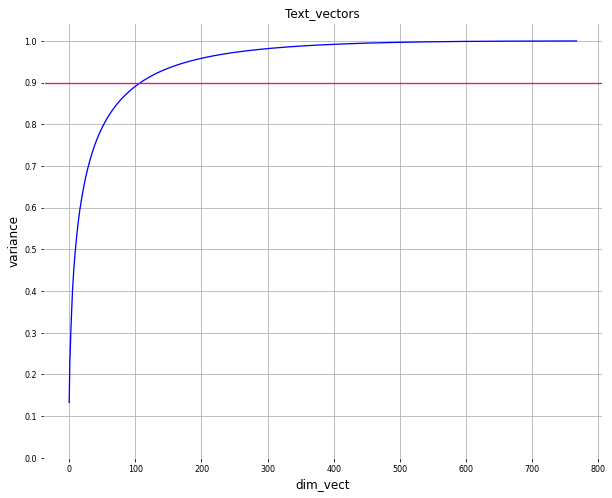

In [ ]:
fig = plt.figure()

plt.plot(np.cumsum(pca.explained_variance_ratio_), color='b', lw=1.3)
plt.yticks(np.arange(0, 1.1, 0.1))

plt.axhline(0.9, c='#FF0086', lw=1.3)
plt.grid()
plt.title('Text_vectors')

plt.xlabel('dim_vect')
plt.ylabel('variance')

plt.show()


In [ ]:
pca_comment = pca.fit_transform(part_data_emd.iloc[:, 773:])

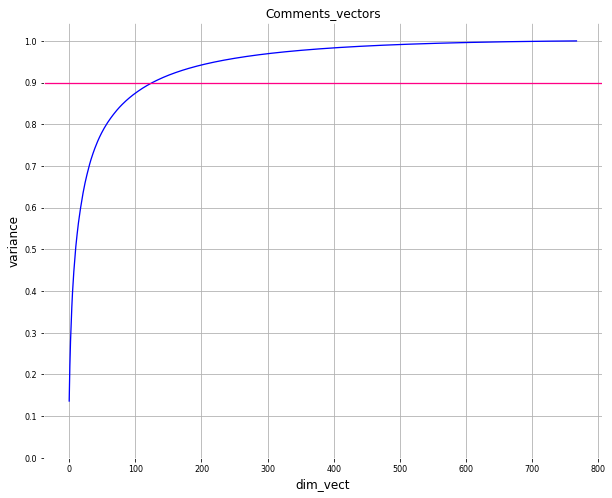

In [ ]:
fig = plt.figure()

plt.plot(np.cumsum(pca.explained_variance_ratio_), color='b', lw=1.3)
plt.yticks(np.arange(0, 1.1, 0.1))

plt.axhline(0.9, c='#FF0086', lw=1.3)
plt.grid()
plt.title('Comments_vectors')

plt.xlabel('dim_vect')
plt.ylabel('variance')

plt.show()

Проанализировав графики можно сказать, что вектора размерностью 100 сохраняют около 90% дисперсии данных. Поэтому можно для дальнейшей работы формировать эмбеддинги с динной не более 100 с помощью функции **text2emb**.<br>
<br>
Для дальнейшего анализа выгрузим еще 5000 записей из средней части df, преобразуем текты в эмбеддинги длинной 100.

In [ ]:
# берем случайные 5000 постов из середины выборки

part_data_2 = train[150000:155000]

In [ ]:
# сформируем эмбеддинги размера 100 для дальнейшего исследования
# для работы функции необходимо подключение GPU
# для удобства полученный файл можно загрузить ниже в готовом виде

# part_data_2_emd, pca_1, pca_2 = text2emb(part_data_2
#                                          , text_col_name='text'
#                                          , comment_col_name='comments'
#                                          , emb_size=100)

# сохраним эмбеддинги в файл
# part_data_2_emd.to_csv('part_data_2_emd.csv', index=False)

part_data_2_emd  = pd.read_csv('/data/part_data_2_emd.csv')

Посмотрим на распределение векторов комментариев в пространстве в зависимости от меток класса с помощью TNSE

In [ ]:
# только эмбеддинги комментариев 2500

commemt_df = part_data_2_emd.iloc[:2500, 105:]

In [ ]:
commemt_df_2_comp = TSNE(n_components=2, perplexity=30, n_iter=1000).fit_transform(commemt_df)

In [ ]:
commemt_score_df = np.concatenate((commemt_df_2_comp, part_data_2_emd['score'][:2500].values.reshape(-1,1)), axis=1)
commemt_score_df = pd.DataFrame(commemt_score_df, columns=['x', 'y', 'score'])
commemt_score_df['score'] = commemt_score_df['score'].astype('category')

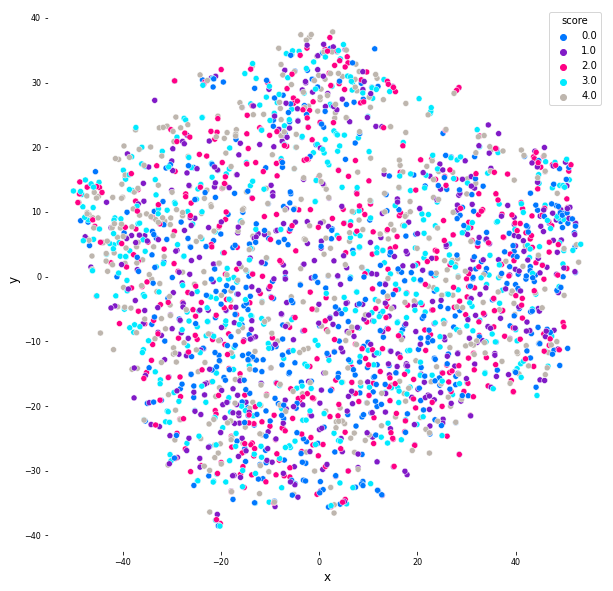

In [ ]:
fig = plt.figure()
fig.set_size_inches(10, 10)

plt.rcParams['image.cmap'] ='cool'
sns.scatterplot(data=commemt_score_df, x='x', y='y', hue='score', palette=colors_vk)

plt.show()

Какие то явные зависмости трудно выделить визуально. Очевидно, что разделение комметариев по степени популярности на наших данных - нетривиальная задача!

## Оценка близости векторов постов и комментариев с помощью косинусного расстояния

Гипотеза: чем ближе контекст комментария к теме поста, тем лучше скор (0) он будет иметь.<br>

Оценим меру схожести векторов (пост-коммент) с помощью косинусного расстояния:<br>
dist = 1 - cos(angel)



In [ ]:
def get_cos_dist(df_row):
    """Берет строку df и расчитывает косинусное расстояния для пары text-comment"""

    from scipy.spatial import distance

    return distance.cosine(df_row[5: 105].values, df_row[105: ].values).round(5)

In [ ]:
# создаем новую колонку с косинусным расстоянием текст-коммент

part_data_2_emd['cos_dist'] = [get_cos_dist(part_data_2_emd.loc[i])
                               for i in range(len(part_data_2_emd))]

In [ ]:
# рассчитаем разницы

def get_cos_dist_diff(df):
    """Расчет разницы косинусного расстояния в одной группе (от score=0)
    """

    cos_dist_diff_list = []
    dist_top_score = 0

    for i in range(len(df)):
        if i % 5 == 0:
            dist_top_score = df.loc[i]['cos_dist']
            cos_dist_diff_list.append(0)
        else:
            cos_dist_diff_list.append((df.loc[i]['cos_dist'] - dist_top_score).round(5))

    return cos_dist_diff_list

In [ ]:
# создаем новую колонку с разницей в косинусных расстояниях комментариев в рамках одного поста
# берем за точку отсчета расстояние скора=0, так как по нашей гипотезе он должен быть ближе всего к тексту

part_data_2_emd['cos_dist_diff'] = get_cos_dist_diff(part_data_2_emd)

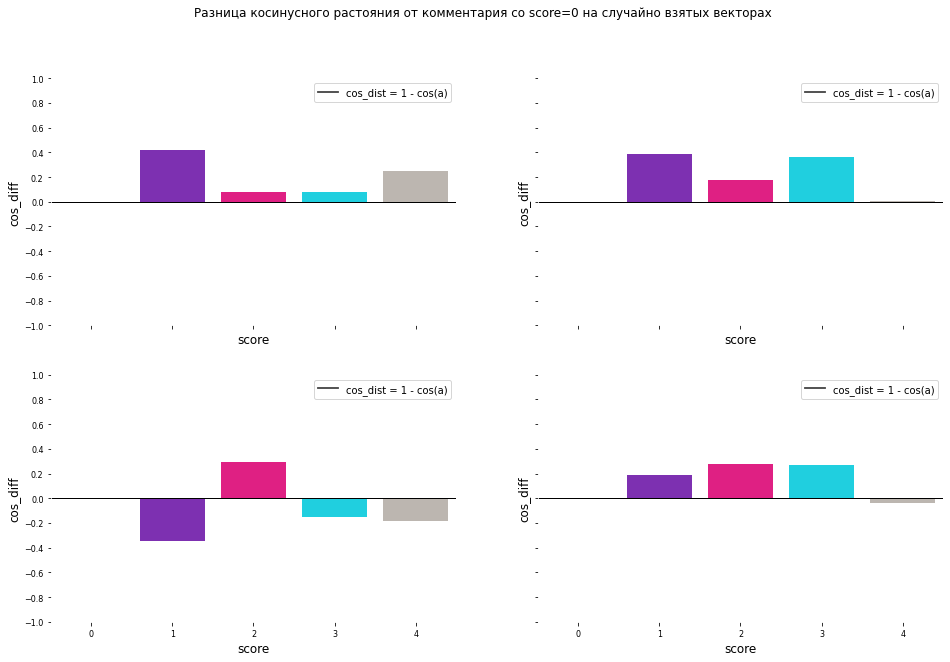

In [ ]:
# Визуализация разницы косинусного комментариев расстояния по одному из случано выбранных постов

fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)
fig.set_size_inches(16, 10)
plots = [(0, 0), (0, 1), (1, 0), (1, 1)]

for xx, yy in plots:
  x = np.random.choice(np.arange(0, len(part_data_2_emd), step=5))
  sns.barplot(x=[0, 1, 2, 3, 4], y=part_data_2_emd['cos_dist_diff'].loc[x: x + 4].values, palette=colors_vk, ax=ax[xx, yy])
  ax[xx][yy].set_yticks(np.arange(-1, 1.2, 0.2))
  ax[xx][yy].axhline(0, c='black')

  ax[xx][yy].set_xlabel('score')
  ax[xx][yy].set_ylabel('cos_diff')
  ax[xx][yy].legend(['cos_dist = 1 - cos(a)'])

plt.suptitle('Разница косинусного растояния от комментария со score=0 на случайно взятых векторах')

plt.show()

На графиках видно, что сколько бы случайных комментариев мы не брали, мы получаем противоречивые результаты.<br>
Посмотрим на распределение векторных расстояний на всем датафрейме ниже c помощью boxplot.

In [ ]:
# формируем дафрейм с разницей косинусных расстояний

score_0 = part_data_2_emd['cos_dist_diff'].loc[np.arange(0, len(part_data_2_emd), step=5)].values
score_1 = part_data_2_emd['cos_dist_diff'].loc[np.arange(1, len(part_data_2_emd), step=5)].values
score_2 = part_data_2_emd['cos_dist_diff'].loc[np.arange(2, len(part_data_2_emd), step=5)].values
score_3 = part_data_2_emd['cos_dist_diff'].loc[np.arange(3, len(part_data_2_emd), step=5)].values
score_4 = part_data_2_emd['cos_dist_diff'].loc[np.arange(4, len(part_data_2_emd), step=5)].values

cos_diff_array = np.hstack((score_0.reshape(-1, 1), score_1.reshape(-1, 1),
           score_2.reshape(-1, 1), score_3.reshape(-1, 1),
           score_4.reshape(-1, 1)))

cos_diff_array = pd.DataFrame(cos_diff_array,
                              columns=('score_0', 'score_1', 'score_2', 'score_3', 'score_4'))

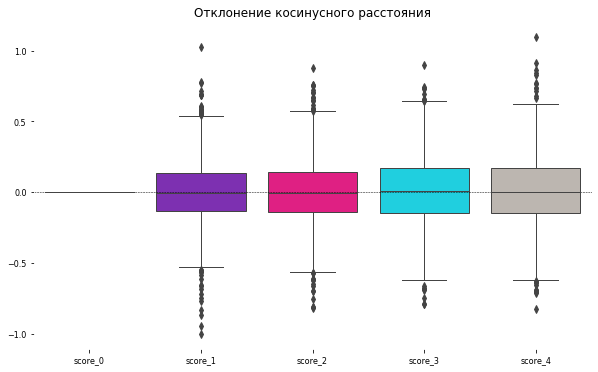

In [ ]:
# рисуем боксплоты

fig = plt.figure()
fig.set_size_inches(10, 6)

plt.axhline(0, c='black', lw=0.5,  linestyle='--')
sns.boxplot(data=cos_diff_array, palette=colors_vk)
plt.title('Отклонение косинусного расстояния')

plt.show()

Присутсвует малозаметная тенденция увеличение медианного значение и квантиля 75 косинусного расстояния при переходе от комметария со score=0 к score=4

In [ ]:
# проверим на наличие статзначимых различий в группах по параметру "косинусное расстояни от вектора score_0"
# p-value получился достаточно высоким (гораздо больше 0.05), мы не можем отвергнуть  Н0 об отсутствии различий в группах.
# вывод: различия в медианах косинусных расстояний от вектора со скором 0 статистически не значимо

cos_dist_groups = []
for col in cos_diff_array.columns:
  group = cos_diff_array[col].values
  cos_dist_groups .append(group)

print(stats.mstats.kruskalwallis(*cos_dist_groups [1:]))

KruskalResult(statistic=1.2594473044021903, pvalue=0.7387844848407132)


Для полноты картины построим еще "*heatmap*" с корреляциями между векторами комментариев

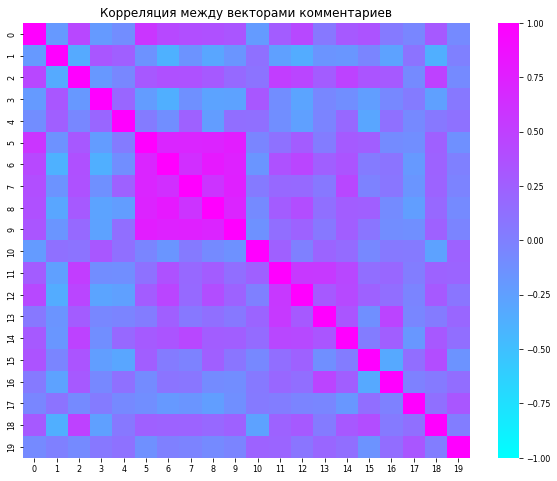

In [ ]:
fig = plt.figure()
# plt.rcParams['image.cmap'] = colors_vk

fig.set_size_inches(10, 8)
sns.heatmap(commemt_df[:20].T.corr(), cmap='cool', vmax=1, vmin=-1)
plt.title('Корреляция между векторами комментариев')

plt.show()

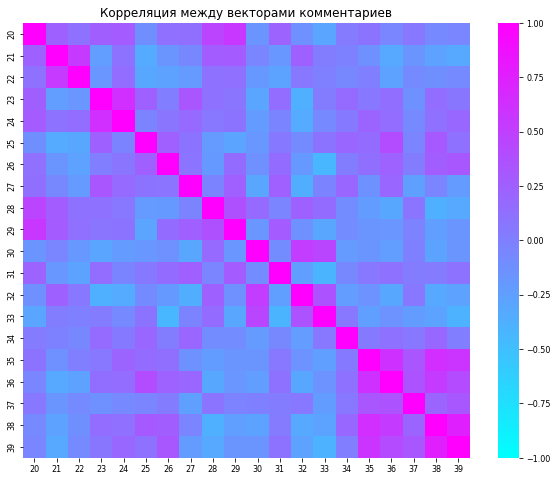

In [ ]:
fig = plt.figure()
fig.set_size_inches(10, 8)

sns.heatmap(commemt_df[20: 40].T.corr(), cmap='cool', vmax=1, vmin=-1)
plt.title('Корреляция между векторами комментариев')

plt.show()

Каких то закономерностей в пожести векторов со одинаковым score в разных постах трудно выделить. Можно увидеть некоторые конгломераты размера 5х5 и менее вдоль диагонали, что свидетествует о похожести комментариев в рамках одного поста. И это логично, так как имееют общую тематику

### *Выводы по эмбеддингам текстов*

На основании проведенных исследований можно сделать вывод, что эмбеддинги текстов коментариев и постов не содержат какой-то явной зависимости со "score". Предполагается, что признаки на освовании емббедингов не только не принесут значительного вклада при обучении моделей, но могут и ухудшить рещультат, зашумив данные. Нужно искать другие законмерности в тектах (длинна постов, количество спецсимволов...) для выделения новых признаков.

## Создание новых признаков и анализ их значимости

Выдвинем следущие предположерния, что может влиять на ***score*** комментария:

1. Размер комментария (чем он длинее, тем осмысленнее и информативнее, тем бОльший отклик вызовет);
2. Количество спецсимволов в комментарии. Идея: если символов слишком много, то автор скорее всего "запикивал" какие-то слова символами $#@. или снежинками. Посчитаем некий "индекс знаков", он будет равен: <br>
(количество спецсимволов + 1) / (количество пробелов + 1);
3. Также посчитаем длину самого поста, в предположении, что соотношение длины поста и длины коммента тоже может влиять на скор.

In [ ]:
# функция для подсчета спецсимволов

def punctuation_index(line):
    qty_signs = len(re.findall(r'[{}]'.format('!"#$%&\'()*+,-.;<=>?@[\\]^_`{|}~'), line))
    qty_spaces = len(re.findall(r'\s', line))
    idx = (qty_signs + 1) / (qty_spaces + 1)

    return idx

In [ ]:
# создаем новые колонки с признаками

train_data['text_lenght'] = train_data['text'].str.len()
train_data['comment_lenght'] = train_data['comments'].str.len()
train_data['comm/text_len_idx'] = train_data['comment_lenght'] / train_data['text_lenght']

train_data['punct_idx'] = train_data['comments'].apply(punctuation_index)


In [ ]:
train_data.head(3)

,post_idx,text,comments,score,text_lenght,comment_lenght,comm/text_len_idx,punct_idx
0,0,How many summer Y Combinator fundees decided n...,Going back to school is not identical with giv...,0,129,998,7.736434,0.155914
1,0,How many summer Y Combinator fundees decided n...,There will invariably be those who don't see t...,1,129,414,3.209302,0.210526
2,0,How many summer Y Combinator fundees decided n...,For me school is a way to be connected to what...,2,129,488,3.782946,0.131868


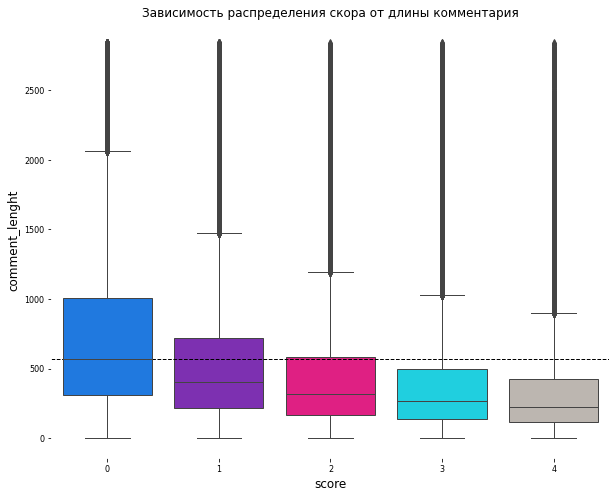

In [ ]:
# распределение score в зависимоти от длины комментария

# уберем выбросы для визуализации
df_plot  = train_data[train_data['comment_lenght'] < np.quantile(train_data['comment_lenght'], 0.99)]
sns.boxplot(x=df_plot['score'], y=df_plot['comment_lenght'], palette=colors_vk)
plt.axhline(df_plot[df_plot['score'] == 0]['comment_lenght'].median(), linestyle='--', color='black')


plt.title('Зависимость распределения скора от длины комментария')

plt.show()

In [ ]:
# прроверим результаты на статтесте
# p-value около нуля, это значит мы уверенно можем отвергнуть нулевую гипотезу об отсутствии различий

punct_idx_groups = []
for col in train_data['score'].unique():
  group = train_data[train_data['score'] == col]['comment_lenght'].values
  punct_idx_groups.append(group)

print(stats.mstats.kruskalwallis(*punct_idx_groups))

KruskalResult(statistic=49175.85850869652, pvalue=0.0)


Наблюдается явная зависимость скора комментария от его длины.



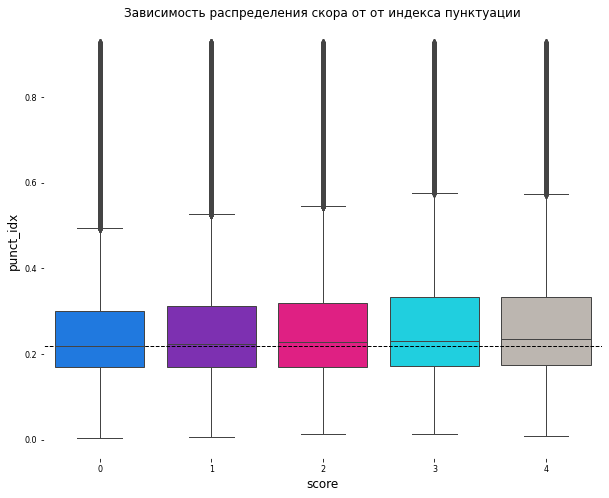

In [ ]:
# распределение score в зависимоти от индекса знаков

# уберем выбросы для визуализации

df_plot  = train_data[train_data['punct_idx'] < np.quantile(train_data['punct_idx'], 0.95)]
sns.boxplot(x=df_plot['score'], y=df_plot['punct_idx'], palette=colors_vk)
plt.axhline(df_plot[df_plot['score'] == 0]['punct_idx'].median(), color='black', linestyle='--')


plt.title('Зависимость распределения скора от от индекса пунктуации')

plt.show()

In [ ]:
# прроверим результаты на статтесте
# p-value около нуля, это значит мы уверенно можем отвергнуть нулевую гипотезу об отсутствии различий

punct_idx_groups = []
for col in train_data['score'].unique():
  group = train_data[train_data['score'] == col]['punct_idx'].values
  punct_idx_groups.append(group)

print(stats.mstats.kruskalwallis(*punct_idx_groups[1:]))

KruskalResult(statistic=591.9416744386203, pvalue=5.627427892627861e-128)


Зависимость скора комментария от количества знаков на предложение тоже очевидна - то есть, чем больше дополнительных символов используется в комментарии, тем менее "лайкообразный" характер он имеет.

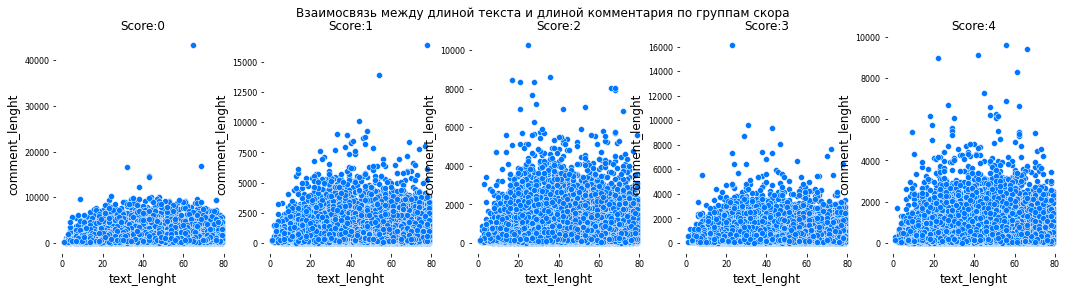

In [ ]:
df_plot  = train_data[train_data['comment_lenght'] < np.quantile(train_data['comment_lenght'], 0.99)]
df_plot  = train_data[train_data['text_lenght'] < np.quantile(train_data['text_lenght'], 0.99)]

fig, ax = plt.subplots(1, 5)
fig.set_size_inches([18, 4])

# plt.rcParams['image.cmap'] ='cool'
for i in range(5):
    sns.scatterplot(x='text_lenght', y='comment_lenght', data=df_plot[df_plot['score']==i], ax=ax[i], color='#0077FF') #palette=colors_vk
    ax[i].set_title(f'Score:{i}')

plt.suptitle('Взаимосвязь между длиной текста и длиной комментария по группам скора')
plt.show()

Визуально не видно взаимосвязи между длиной текста и коммента. Но оставим этот признак для обучения моделей и оценим по результатам обучения модели.

### *Выводы по гипотезам*
- Наблюдается положительная зависимость ***score*** от длинны комментария. Возможно длинный комментарий содержит более полезной информации и соответвенно оценивается выше
- Присутвует отрицательная зависимоть между ***score*** и количеством спецсимвовлов в комментарии. Возможно спецсиволы закрывают ненормативную лексику и тем самым делает его менее популярным
- Не очевидной зависимости длина текста/ длина комментария

## Оценка зависимости ***score*** от эмоциональнотсти комментария

Попробуем уловить зависимость скора комментария от его эмоционального окраса. Для этого воспользуемся готовой моделью twitter-roberta-base, обученной на постах из твиттера.

In [ ]:
# Preprocess text (username and link placeholders)
def preprocess(text):
    new_text = []

    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

# Tasks:
# emoji, emotion, hate, irony, offensive, sentiment
# stance/abortion, stance/atheism, stance/climate, stance/feminist, stance/hillary

task='sentiment'
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"

tokenizer = AutoTokenizer.from_pretrained(MODEL)

In [ ]:
# download label mapping
labels = []

mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/mapping.txt"
with urllib.request.urlopen(mapping_link) as f:
    html = f.read().decode('utf-8').split("\n")
    csvreader = csv.reader(html, delimiter='\t')
labels = [row[1] for row in csvreader if len(row) > 1]

# PT
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
model.save_pretrained(MODEL)

In [ ]:
def estimate_sentiment(text):
    text = preprocess(text)
    encoded_input = tokenizer(text, return_tensors='pt', max_length=512, truncation=True)
    output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)

    return scores.round(4)

In [ ]:
# код для обработки столбца 'comments'- создает новый столбец с вероятностью эмоции - негативной, нейтральной, позитивной

# train_data['emotion] = train_data['comments'].apply(estimate_sentiment) -

# data_emo = data_emo.rename(columns={'neg': 'negative_prob', 'neutr': 'neutral_prob',	'pos': 'positive_prob',	'emo': 'emotion'})
# разделим эмоции по разным столбцам
# ddf['negative_prob'] = df_emo['comments'].apply(lambda x: x[0])
# ddf['neutral_prob'] = df_emo['comments'].apply(lambda x: x[1])
# ddf['positive_prob'] = df_emo['comments'].apply(lambda x: x[2])
# ddf['emotion'] = ddf[['neg', 'neutr', 'pos']].idxmax(axis=1)

# так как код выше работает долго - загрузим посчитанные данные
data_emo = pd.read_csv('/data/emo_features.csv')


In [ ]:
data_emo.head(4)

,index,index_post,negative_prob,score,neutral_prob,positive_prob,emotion
0,0,0,0.6982,0.0,0.2645,0.0373,neg
1,1,0,0.0514,1.0,0.3629,0.5858,pos
2,2,0,0.0061,2.0,0.0690,0.9250,pos
3,3,0,0.0398,3.0,0.3847,0.5755,pos


In [ ]:
# кросс таблица распределения скоров и эмоционалтных лейблов

crosstab = pd.crosstab(data_emo['emotion'], data_emo['score']).transpose()
crosstab

emotion,neg,neutr,pos
score,,,
0.0,1920,2376,1704
1.0,1791,2311,1898
2.0,1727,2338,1935
3.0,1591,2433,1976
4.0,1586,2487,1927


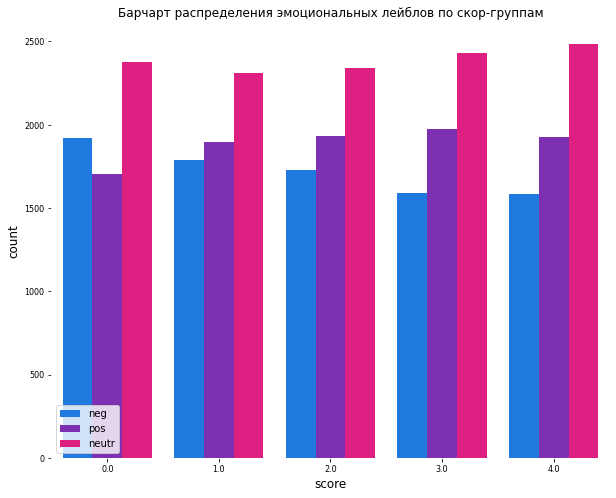

In [ ]:
# барчарт распределения эмоциональных лейблов по скор-группам

sns.countplot(x='score', hue='emotion', data=data_emo, palette=colors_vk)

plt.title('Барчарт распределения эмоциональных лейблов по скор-группам')
plt.legend(loc='lower left')

plt.show()

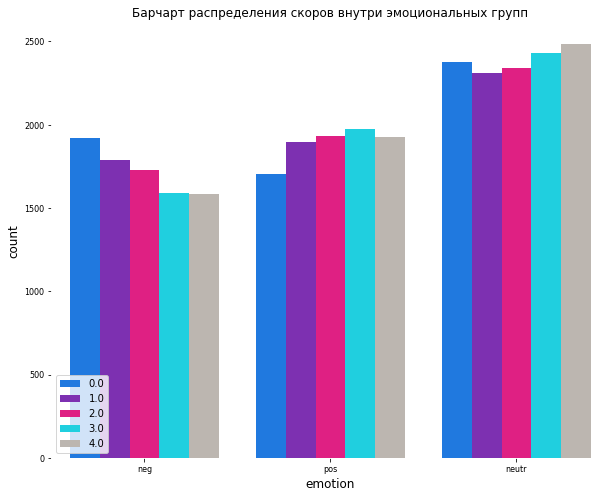

In [ ]:
# барчарт распределения скоров внутри эмоциональных групп

sns.countplot(x='emotion', hue='score', data=data_emo, palette=colors_vk)

plt.title('Барчарт распределения скоров внутри эмоциональных групп')
plt.legend(loc='lower left')

plt.show()

### *Выводы*

- Визуально выделяется сдвиг в сторону негативной экспрессии в группах со скором 0, то есть, негативные комментарии вызывают бОльший отклик.
- Также есть обратная тенденция - в группах с позитивным посылом сдвиг в сторону худшего скора.
- Нейтральные комментриии распределены равномерно.


## Выбор модели машинного обучения

Возьмем два метода оценки признака:
1. Рeгрессионные модели:
предскажем вещественное число и распределим скоры в зависимости от величины полученного предсказания (чем выше значение предсказания - тем больше значение скора, ранжируем от 0 до 4)
<br>
2. Модели классификации:
Есть трудность с мультиклассовой классификацией, так как у нас разные комеметарии к одному посту могут получить одинаковую метку, что приведет к ошибкам ранжирования. Поступим следующим образом: объединим скоры 0, 1, 2 в группу "0", а скоры 3, 4 в группу "1". Затем проведем классификацию и получим вероятности, что коммент относится к объединенным группам 0 или 1. <br> Проранжируем посты по вероятности принадлежности к группе 1 и проставим лейблы от 0 до 4. Таким образом получится, что чем меньше вероятность принадлежать объединенной группе 1, тем больше вероятность принадлежать к объединенной группе 0, тем лучше будет присвоен скор (чем меньше скор - тем лучше)

3. В качестве моделей возьмем RandomForest и Catboost <br>

In [ ]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, multilabel_confusion_matrix, classification_report, accuracy_score, ndcg_score
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression
from catboost import CatBoostClassifier, CatBoostRegressor

In [ ]:
# формируем датасет со всеми призаками (вектора текстов, постов, текстовые метрики)
train_data.head()

,post_idx,text,comments,score,text_lenght,comment_lenght,comm/text_len_idx,punct_idx
0,0,How many summer Y Combinator fundees decided n...,Going back to school is not identical with giv...,0,129,998,7.736434,0.155914
1,0,How many summer Y Combinator fundees decided n...,There will invariably be those who don't see t...,1,129,414,3.209302,0.210526
2,0,How many summer Y Combinator fundees decided n...,For me school is a way to be connected to what...,2,129,488,3.782946,0.131868
3,0,How many summer Y Combinator fundees decided n...,I guess it really depends on how hungry you ar...,3,129,318,2.465116,0.138462
4,0,How many summer Y Combinator fundees decided n...,I know pollground decided to go back to school...,4,129,81,0.627907,0.071429


In [ ]:
# отделяем таргет от признаков

X = train_data.loc[:, 'text_lenght':]
y = train_data['score']

In [ ]:
# делим выборку на трейн и тест вручную, чтобы количество было кратно 5

X_train = X.iloc[:356535] #.drop('text_lenght', axis=1)
X_test = X.iloc[356535:] #.drop('text_lenght', axis=1)
y_train = y.iloc[:356535]
y_test = y.iloc[356535:]

# создаем матрицу по оценкам постов, чтобы считать метрику nCDG
y_test_groups = np.array(y_test).reshape(-1, 5)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((356535, 4), (84000, 4), (356535,), (84000,))

In [ ]:
# датафрейм с бинарными колонками для моделей классификации

y_train_bin = y_train.copy()
y_train_bin = y_train_bin.map({0: 0, 1: 0, 2: 0, 3: 1, 4: 1})

y_test_bin = y_test.copy()
y_test_bin = y_test_bin.map({0: 0, 1: 0, 2: 0, 3: 1, 4: 1})

In [ ]:
# LR

LR = LinearRegression(fit_intercept=True)
LR.fit(X_train, y_train)

LinearRegression()

In [ ]:
# CB binary

CBC = CatBoostClassifier(verbose=1, random_state=1)
CBC.fit(X_train, y_train_bin)

In [ ]:
# CBR

CBR = CatBoostRegressor(verbose=1, random_state=1)
CBR.fit(X_train, y_train_bin)

In [ ]:

model_dict = { 'LinearRegression' : {'model': LR, 'method': 'regression'}
              , 'CatBoostClassifier': {'model': CBC, 'method': 'bin_classif'}
              , 'CatBoostCRegressor': {'model': CBR, 'method': 'regression'}
              }

def evaluate_metrics(model_name, model, method):
    if method == 'bin_classif':
        predictions = model.predict_proba(X_test)[:, 1]
    else:
        predictions = model.predict(X_test)

    y_pred_matrix = predictions.reshape(-1, 5)
    y_pred_matrix =  y_pred_matrix.argsort().argsort()
    y_pred_linear = y_pred_matrix.reshape(-1, 1)

    print(f'{model_name}: acccuracy score {accuracy_score(y_test, y_pred_linear).round(4)}')
    print(f'{model_name}: nDCG score {ndcg_score(y_test_groups, y_pred_matrix).round(4)}')
    print('\n')

for model_name in model_dict:
    evaluate_metrics(model_name, model_dict[model_name]['model'], model_dict[model_name]['method'])


LinearRegression: acccuracy score 0.3322
LinearRegression: nDCG score 0.8856


CatBoostClassifier: acccuracy score 0.3256
CatBoostClassifier: nDCG score 0.8854


CatBoostCRegressor: acccuracy score 0.3266
CatBoostCRegressor: nDCG score 0.8856




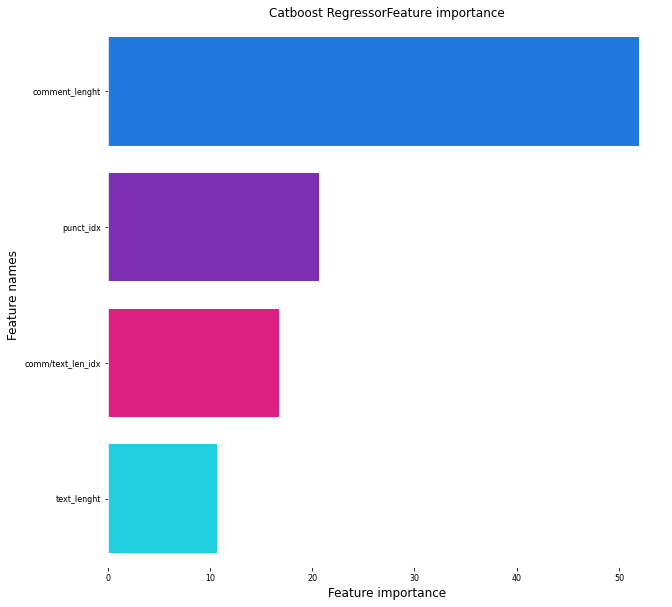

In [ ]:
# отрисуем барчарт с вкладом признаков

def plot_feature_importance(importance,names,model_type):

    # массивы данных оценки важности и имен
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    # создаем дв имя - важность
    data = {'feature_names': feature_names,'feature_importance': feature_importance}
    fi_df = pd.DataFrame(data)

    # сортируем по убыванию важности
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    # отрисовка
    plt.figure(figsize=(10, 10))
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'], palette=colors_vk)

    plt.title(model_type + 'Feature importance')
    plt.xlabel('Feature importance')
    plt.ylabel('Feature names')


plot_feature_importance(CBR.feature_importances_, X_train.columns,'Catboost Regressor')

Как видим, самый большой вклад в предсказание результата делает признак "длина текста", также большую роль сыграли признаки "индекс пунктуации"

### *Выводы по моделям*

- Среди выбранных моделей из разных семейств оптимальным выбором будет ***CatBoostRegressor***
- Согласно ***feature_importance*** наши новые признаки оказались значимыми

## Результаты исследования

1) Векторные представления постов и тектов плохо различимы в рамках ранжирования от 0 до 4. Не могут быть надежной опрой для формирования признаков;

2) Признаки на основаниии структуры текста дают хорошие статистически значимые результаты. Что позволяет моделям качественно прозвести разделение и достичь хороших показателей метрики nDCG;

3) Выявеление эмоциональной характеристики коментария с помощью нейронных сетей - хорошая идея. Несмотря на то что, мы получили не очень оптимистичные выводы(негативно окрашенные комментарии в среднем популярнее нейтральных и позитивных), тем не менее они коррелируют с другими медиа-сферами, как телевидиние - провокационные, сенсационные и другие программы имеют выше рейтинг. В этом направлении еще можно поработать, выделив другие эмоциональные составляющие текста (радость/грусть,  сентимментальность/грубость) и найти зависимости с рейтингом комментария.

## Формирование предсказаний на валидационной выборке

In [ ]:
df_preds = test_data.copy()

In [ ]:
# создадим фичи с признаками

df_preds['text_lenght'] = df_preds ['text'].str.len()
df_preds['comment_lenght'] = df_preds['comments'].str.len()
df_preds['comm/text_len_idx'] = df_preds['comment_lenght'] / df_preds['text_lenght']

df_preds['punct_idx'] = df_preds['comments'].apply(punctuation_index)

df_preds.drop(['score', 'text', 'comments'], axis=1, inplace=True)

In [ ]:
# сделаем предсказание

predictions = CBR.predict(df_preds)
predictions = predictions.reshape(-1, 5)
predictions = predictions.argsort().argsort()
predictions = predictions.reshape(-1, )

test_data['score'] = predictions

In [ ]:
# функция для схлопывания результатов обратно в json

final_df = pd.DataFrame(columns = ['text', 'comments'])
start = 0
df = test_data.copy()
for i in range(0, df.shape[0], 5):
        text = df.iloc[i]['text']
        finish = start + 5
        comments = []
        for i in range(start, finish):
            comment = {'text': df.iloc[i]['comments'], 'score': df.iloc[i]['score']}
            comments.append(comment)
        final_df = final_df.append({'text' :text, 'comments': comments}, ignore_index=True)
        start = finish

In [ ]:
# сохраняем файл

final_jsonl = final_df.to_json('/data/final_j.jsonl', orient='records', lines=True, force_ascii=False)

# Инсайты и предложения

- Более длинный комментарий в среднем популярнее других. Пользователям лучше писать полный коментарий, в котором раскрывется мысль, что он хотел донести. Возможно использовать какую то аргументацию своей позиции. Пользователю это можно интерактивно подсказывать

- В наших данных имеются комментарии с использованием подряд спецсимволов (№"%&$...). Это можно интерпретировать как наличие ненормативной лексики. Согласно исследованию, это отрицательно сказывается на популярность комментария. Следовательно пользователю лучше воздержаться от использования нецензурных слов в своих сообщениях. При попытке написать такие слова, пользователю это можно подсвечивать с комментариями

- Комментарий должен коррелирровать с темой поста, раскрывать и дополнять его тему. В таком случае комментарий будет более популярен

- Есть зависимость от эмоциональной окраски комментария. В нашем случае получились неутешительные выводы, но соответвущие действительности: негативные комментарии имеют больше внимания (как и рейтинг передач на телевидинии, как Андрей Малахов и др.). С точки срения бизнеса нам невыгодно, чтобы общение сходилось на негатив. Возможно нужно выделить другие эмоциональные составляющие комментариев и проанализивать их в дальнейшем. Эту информацию можно опять использовать и подсвечивать пользователю эмоцианальный окрас сообщения

- И конечно все рекоммендации должны даваться пользователем ненавязчиво. Иначе это может быть воспринято как посягательство на его свободу. Конечно он в праве писать что угодно и выражать свои мысли как он считает правильным